In [1]:
from mne.io import read_raw_edf

file_path = "eeg_file/01IS-1-ADP.edf"
raw = read_raw_edf(file_path, preload=True)

sampling_rate = int(raw.info['sfreq'])
signal = raw.get_data(picks="eeg")[2]

Extracting EDF parameters from /media/artem/data/Dev/Sleep_analysis/eeg_file/01IS-1-ADP.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7529215  =      0.000 ... 29410.996 secs...


In [2]:
from signal_periodizer.periodizer import SignalPeriodizer

periodizer = SignalPeriodizer(point_per_period=sampling_rate * 20)
last_period = periodizer.last_period_for(signal=signal)

print(f"{last_period=}")

last_period=1469


In [16]:
import math
from tqdm import tqdm
from fft_analyser.homebrew import FftHomebrew
from fft_analyser.welch import FftWelch


# fft_analyser = FftHomebrew(sampling_rate=sampling_rate)
fft_analyser = FftWelch(sampling_rate=sampling_rate, point_per_segment=sampling_rate * 30, overlap=sampling_rate * 2)

all_fft_analysis = {}
all_signal_period = {}

for period in tqdm(range(last_period + 1)):
    current_signal = periodizer.period_for(signal=signal, n_of_period=period)
    all_signal_period[period] = current_signal

    result = fft_analyser.compute_for(signal=current_signal)
    all_fft_analysis[period] = {key: 10 * math.log10(value) for key, value in result.items()}


100%|██████████| 1470/1470 [00:00<00:00, 1912.24it/s]


In [17]:
from matplotlib import gridspec, pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact


def compute_graph_for_a_period(fft_analysis, signal_period, period=0):
    fft = fft_analysis[period]
    signal = signal_period[period]

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4])
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    ax0.plot(signal)

    max_frequency = 30.
    until_max_freq_keys = [key for key in fft.keys() if key <= max_frequency]
    until_max_freq_value = [value for idx, value in enumerate(fft.values()) if idx < len(until_max_freq_keys)]

    ax1.plot(until_max_freq_keys, until_max_freq_value)

    plt.show()


def interactive_plot():
    period_slider = widgets.IntSlider(value=52, min=0, max=last_period, step=1, description="Period:")
    interact(compute_graph_for_a_period,
             fft_analysis=widgets.fixed(all_fft_analysis),
             signal_period=widgets.fixed(all_signal_period),
             period=period_slider)


interactive_plot()

interactive(children=(IntSlider(value=52, description='Period:', max=1469), Output()), _dom_classes=('widget-i…

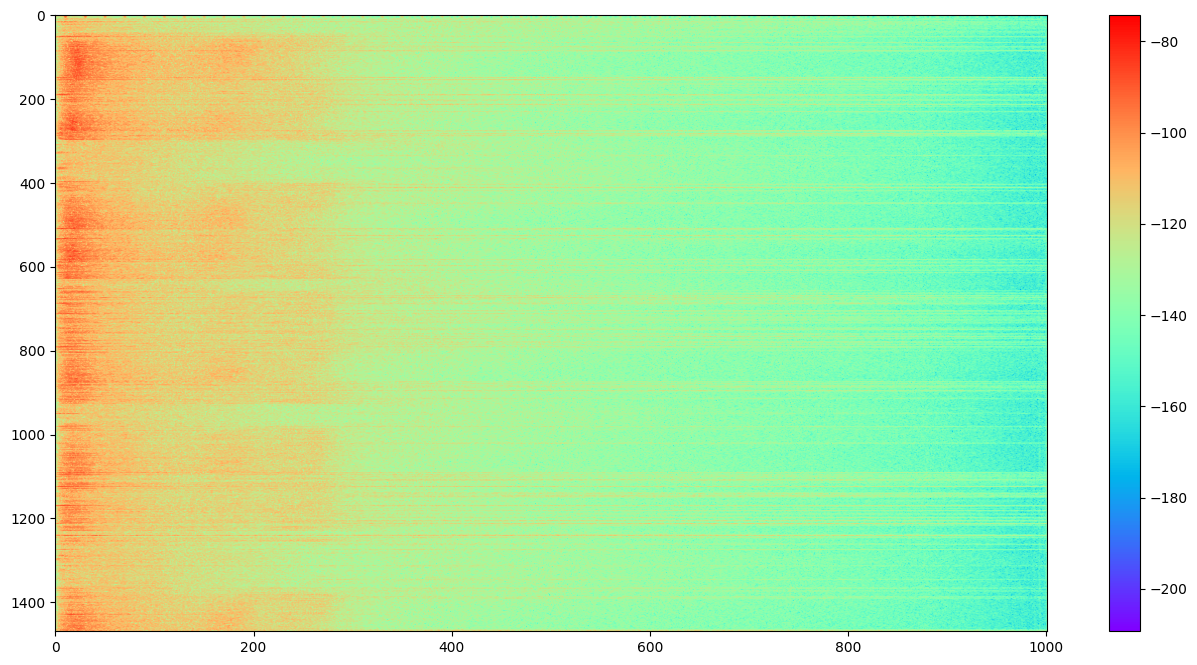

In [18]:
import math

data = all_fft_analysis.copy()

frequencies = [frequency for frequency in all_fft_analysis[0].keys() if frequency <= 50]
len_freq = len(frequencies)

power_values = [[value for value in a_period.values()][:len_freq] for a_period in data.values()]

# Plot the heatmap
plt.figure(figsize=(16, 8))
plt.imshow(
    power_values,
    aspect='auto',
    cmap='rainbow'
)
# Add color bar
cbar = plt.colorbar()

plt.show()

